In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
from xgcm import Grid

In [2]:
db='panant.db'
session=cc.database.create_session(db)

In [3]:
client = Client(n_workers=48)
client

Client Scheduler: tcp://127.0.0.1:42041 Dashboard: /proxy/8787/status,Cluster Workers: 48 Cores: 48 Memory: 202.48 GB


In [4]:
tos = cc.querying.getvar('panan','tos', session)
tos

<xarray.DataArray 'tos' (time: 365, yh: 1690, xh: 7200)>
dask.array<concatenate, shape=(365, 1690, 7200), dtype=float32, chunksize=(31, 1690, 7200), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 -81.1 -81.08 -81.06 -81.03 ... -37.16 -37.12 -37.08
  * time     (time) object 1991-01-01 12:00:00 ... 1991-12-31 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

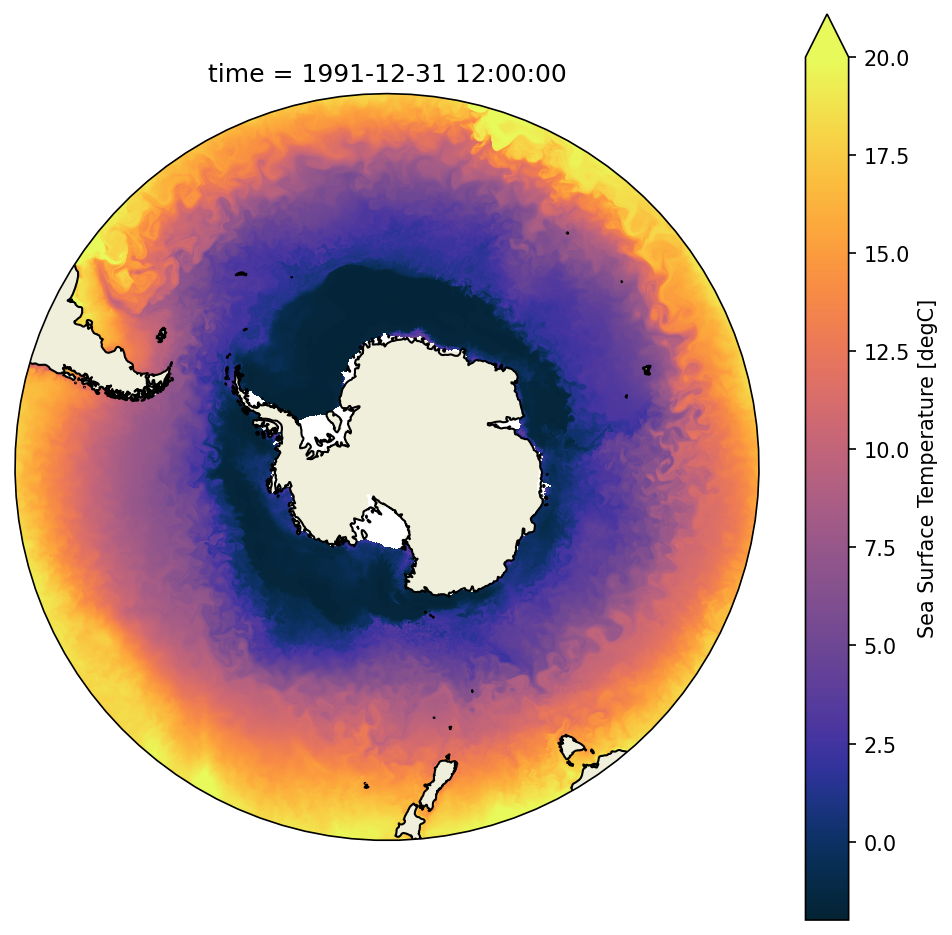

In [5]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = plt.subplot(1, 1, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

tos.isel(time=-1).plot(vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cm.cm.thermal)

In [6]:
zos = cc.querying.getvar('panan','zos', session,chunks={'xh':100,'yh':100})
zos

,Array,Chunk
Bytes,17.77 GB,1.24 MB
Shape,"(365, 1690, 7200)","(31, 100, 100)"
Count,29388 Tasks,14688 Chunks
Type,float32,numpy.ndarray


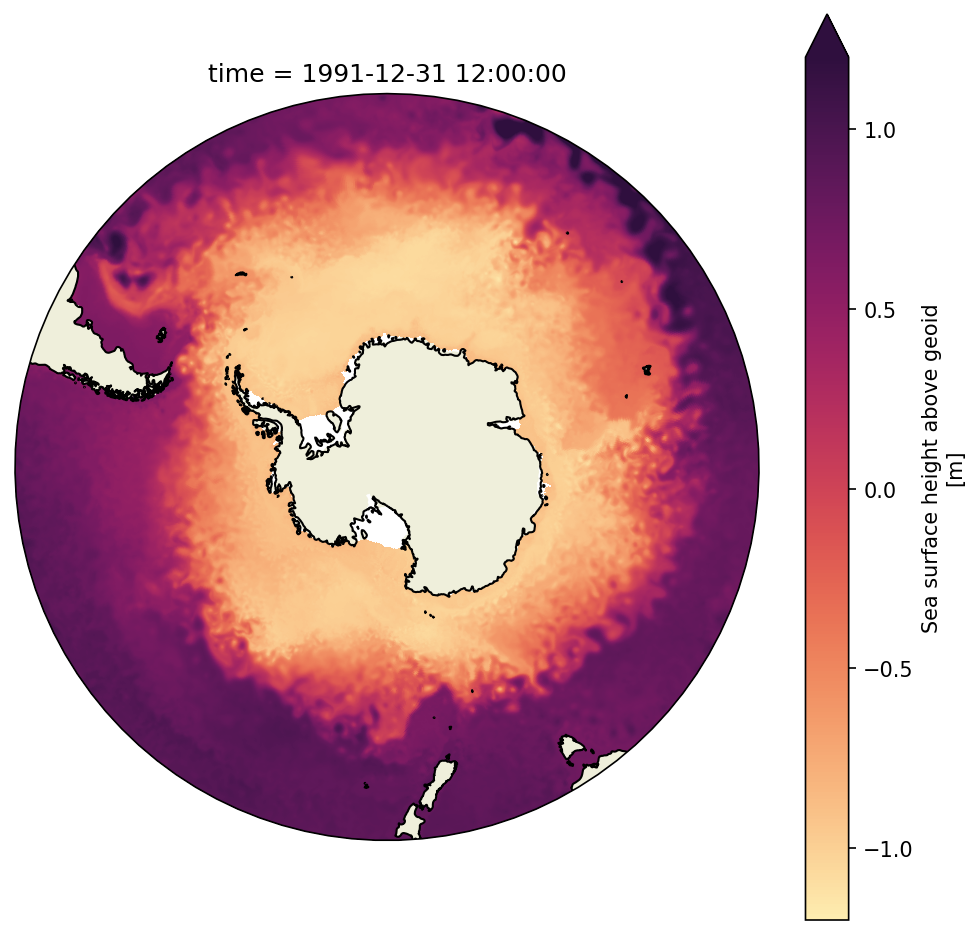

In [7]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = plt.subplot(1, 1, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

zos.isel(time=-1).plot(vmin=-1.2,vmax=1.2,transform=ccrs.PlateCarree(),cmap=cm.cm.matter)

## Plot speed
Need to use `xgcm` to interpolate `u` and `v` onto a common grid. The method below appears to work ...

In [4]:
u_surf = cc.querying.getvar('panan','u_surf', session,chunks={'time':1,'xh':100,'yh':100}).isel(time=-1)
v_surf = cc.querying.getvar('panan','v_surf', session,chunks={'time':1,'xh':100,'yq':100}).isel(time=-1)
ds = xr.merge([u_surf, v_surf])
ds.coords['xh'].attrs.update(axis='X')
ds.coords['xq'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yh'].attrs.update(axis='Y')
ds.coords['yq'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
ds

<xarray.Dataset>
Dimensions:  (xh: 7200, xq: 7201, yh: 1690, yq: 1691, z_l: 1)
Coordinates:
  * yh       (yh) float64 -81.1 -81.08 -81.06 -81.03 ... -37.16 -37.12 -37.08
    time     object 1991-12-31 12:00:00
  * xq       (xq) float64 -280.0 -279.9 -279.9 -279.8 ... 79.85 79.9 79.95 80.0
  * z_l      (z_l) float64 2.5
  * xh       (xh) float64 -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yq       (yq) float64 -81.11 -81.09 -81.07 -81.05 ... -37.14 -37.1 -37.06
Data variables:
    u_surf   (z_l, yh, xq) float32 dask.array<chunksize=(1, 100, 7201), meta=np.ndarray>
    v_surf   (z_l, yq, xh) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>

In [5]:
grid = Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   z_l
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center

In [6]:
u = grid.interp(ds.u_surf, 'X')
v = grid.interp(ds.v_surf, 'Y', boundary='extend')
speed = (u**2 + v**2)**(0.5)

In [7]:
speedlast = speed.isel(z_l=0).load()

Text(0.5, 1.0, '')

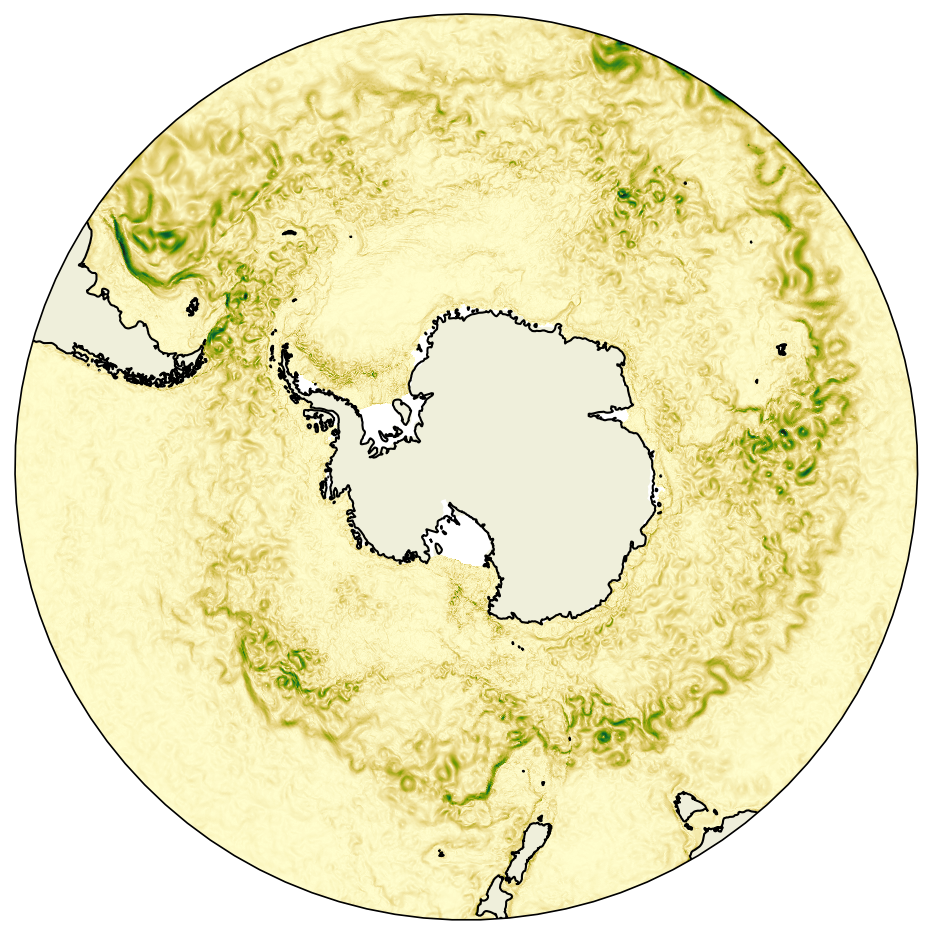

In [8]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = plt.subplot(1, 1, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

speedlast.plot(add_colorbar=False,vmin=0,vmax=0.7,transform=ccrs.PlateCarree(),cmap=cm.cm.speed)
plt.title('')

In [9]:
u_surf = cc.querying.getvar('panan','u_surf', session,chunks={'time':1,'xh':100,'yh':100}).isel(z_l=0)
v_surf = cc.querying.getvar('panan','v_surf', session,chunks={'time':1,'xh':100,'yq':100}).isel(z_l=0)
ds = xr.merge([u_surf, v_surf])

fig = plt.figure(figsize=(8, 8), dpi=150)
for ii in range(60,365):
    
    ds_frame = ds.isel(time=ii)
    
    u = grid.interp(ds_frame.u_surf, 'X')
    v = grid.interp(ds_frame.v_surf, 'Y', boundary='extend')
    speed = (u**2 + v**2)**(0.5)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.coastlines(resolution='50m')
    ax.add_feature(cft.LAND)
    ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())

    ax.set_boundary(circle, transform=ax.transAxes)

    speed.plot(add_colorbar=False,vmin=0,vmax=0.7,transform=ccrs.PlateCarree(),cmap=cm.cm.speed)
    plt.title('')
    
    filestr = '/g/data/x77/amh157/frames/image%04d.png' % ii
    plt.savefig(filestr,dpi=150)
    plt.clf()
    print(ii)

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


177


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


178


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364


<Figure size 1200x1200 with 0 Axes>

In [3]:
!ffmpeg -framerate 20 -pattern_type glob -i '/g/data/x77/amh157/frames/image*.png' -s 1200x1200 -c:v libx264 -pix_fmt yuv420p SpeedPanAnt.mp4

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libs